In [53]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# SWITCH: DenseNet121 is the gold standard for X-ray classification (CheXNet)
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight
import seaborn as sns

In [54]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS_HEAD = 10
EPOCHS_FINE = 25        # DenseNet needs more epochs to converge
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FINE = 1e-5
USE_MOCK_DATA = True    # Set False for real training
DATASET_PATH = r'C:\Users\HP\Videos\COVID-19_Radiography_Dataset' 

CLASSES = ['covid', 'normal', 'viral']

In [55]:
def build_densenet_model(input_shape):
    """
    Builds a DenseNet121 model.
    DenseNet connects every layer to every other layer, making it
    excellent for detecting subtle texture changes in X-rays.
    """
    print("[INFO] Loading DenseNet121 (CheXNet Standard)...")
    
    base_model = DenseNet121(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        
        # DenseNet features are very rich, we don't need massive dense layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(3, activation='softmax') 
    ])

    # OPTIMIZATION: Label Smoothing helps prevent "Overconfident Wrong Predictions"
    loss_fn = losses.CategoricalCrossentropy(label_smoothing=0.1)
    
    model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE_HEAD),
                  loss=loss_fn, 
                  metrics=['accuracy'])
    
    return model, base_model

In [56]:
def get_data_generators(data_dir):
    print("[INFO] Setting up Advanced Data Augmentation...")
    
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input, 
        rotation_range=15,       # Reduced rotation (lungs are usually upright)
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.8, 1.2], # CRITICAL: Handles different X-ray exposures
        horizontal_flip=True,
        fill_mode='constant',    # Constant black fill often better for X-ray edges
        cval=0,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    return train_generator, validation_generator

In [58]:
def calculate_class_weights(generator):
    labels = generator.classes
    class_weights_val = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    class_weights_dict = dict(enumerate(class_weights_val))
    print(f"[INFO] Balanced Class Weights: {class_weights_dict}")
    return class_weights_dict

In [59]:
def generate_mock_data(samples=100):
    print(f"[MOCK] Generating {samples} images...")
    X = np.random.randint(0, 255, (samples, IMG_HEIGHT, IMG_WIDTH, 3)).astype(np.float32)
    # DenseNet preprocess scales 0-255 to 0-1 and normalizes with ImageNet mean/std
    X = preprocess_input(X) 
    Y_indices = np.random.randint(0, 3, samples)
    Y = tf.keras.utils.to_categorical(Y_indices, num_classes=3)
    return X, Y

In [60]:
def evaluate_model(model, X_test, Y_test, is_generator=False):
    print("\n--- Final Evaluation ---")
    if is_generator:
        X_test.reset()
        Y_pred_probs = model.predict(X_test)
        Y_true = X_test.classes
    else:
        Y_pred_probs = model.predict(X_test)
        Y_true = np.argmax(Y_test, axis=1)

    Y_pred = np.argmax(Y_pred_probs, axis=1)

    acc = accuracy_score(Y_true, Y_pred)
    print(f"Test Accuracy: {acc * 100:.2f}%")
    print(classification_report(Y_true, Y_pred, target_names=CLASSES))

    cm = confusion_matrix(Y_true, Y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

=== COVID-19 DENSENET121 TRAINING PIPELINE ===
[INFO] Loading DenseNet121 (CheXNet Standard)...
[MOCK] Generating 300 images...
[MOCK] Generating 60 images...

[PHASE 1] Training Classifier Head...
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.3392 - loss: 1.7503
Epoch 1: val_accuracy improved from None to 0.33333, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.3400 - loss: 1.7727 - val_accuracy: 0.3333 - val_loss: 1.1742 - learning_rate: 0.0010
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.4128 - loss: 1.4147
Epoch 2: val_accuracy improved from 0.33333 to 0.35000, saving model to best_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4233 - loss: 1.4404 - val_accuracy: 0.3500 - val_loss: 1.2753 - learning_rate: 0.0010
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.5150 - loss: 1.2570
Epoch 3: val_accuracy did not improve from 0.35000
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5133 - loss: 1.3177 - val_accuracy: 0.3500 - val_loss: 1.3868 - learning_rate: 0.0010
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.5323 - loss: 1.2646
Epoch 4: val_accuracy did not improve from 0.35000

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5200 - loss: 1.3010 - val_accuracy: 0.3500 - val_loss: 1.2367 - learning_rate: 0.0010
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.5997 - loss: 1.0686
Epoch 5: val_accuracy did not improve from 0.35000
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5967 - loss: 1.0758 - val_accuracy: 0.3500

10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3367 - loss: 1.7889 - val_accuracy: 0.3667 - val_loss: 1.1615 - learning_rate: 1.0000e-05
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3805 - loss: 1.5868
Epoch 2: val_accuracy did not improve from 0.36667
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3767 - loss: 1.5933 - val_accuracy: 0.3333 - val_loss: 1.1510 - learning_rate: 1.0000e-05
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3347 - loss: 1.7087
Epoch 3: val_accuracy did not improve from 0.36667
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3633 - loss: 1.6483 - val_accuracy: 0.3500 - val_loss: 1.1396 - learning_rate: 1.0000e-05
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.4084 - loss: 1.4995
Epoch 4: val_accuracy did not improve from 0.36667
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3933 - loss: 1.5286 - val_accuracy: 0.3333 - val_loss: 1.1249 - learning_rate: 1.0000e-05
Epoch 5/25
10/10 ━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3600 - loss: 1.5776 - val_accuracy: 0.3833 - val_loss: 1.1032 - learning_rate: 1.0000e-05
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4123 - loss: 1.5044
Epoch 7: val_accuracy did not improve from 0.38333
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3867 - loss: 1.5799 - val_accuracy: 0.3833 - val_loss: 1.0987 - learning_rate: 1.0000e-05
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3767 - loss: 1.6494
Epoch 8: val_accuracy did not improve from 0.38333
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3800 - loss: 1.6358 - val_accuracy: 0.3833 - val_loss: 1.0943 - learning_rate: 1.0000e-05
Epoch 9/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1000ms/step - accuracy: 0.3838 - loss: 1.5556
Epoch 9: val_accuracy did not improve from 0.38333
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4133 - loss: 1.4532 - val_accuracy: 0.3667 - val_loss: 1.0921 - learning_rate: 1.0000e-05
Epoch 10/25
10/10 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4700 - loss: 1.3949 - val_accuracy: 0.4500 - val_loss: 1.0907 - learning_rate: 1.0000e-05
Epoch 12/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4577 - loss: 1.4114
Epoch 12: val_accuracy did not improve from 0.45000
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4533 - loss: 1.4215 - val_accuracy: 0.4500 - val_loss: 1.0925 - learning_rate: 1.0000e-05
Epoch 13/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.4143 - loss: 1.4592
Epoch 13: val_accuracy did not improve from 0.45000
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4467 - loss: 1.3926 - val_accuracy: 0.4500 - val_loss: 1.0955 - learning_rate: 1.0000e-05
Epoch 14/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4847 - loss: 1.2301
Epoch 14: val_accuracy did not improve from 0.45000

Epoch 14: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4967 - loss: 1.2888 - val_acc

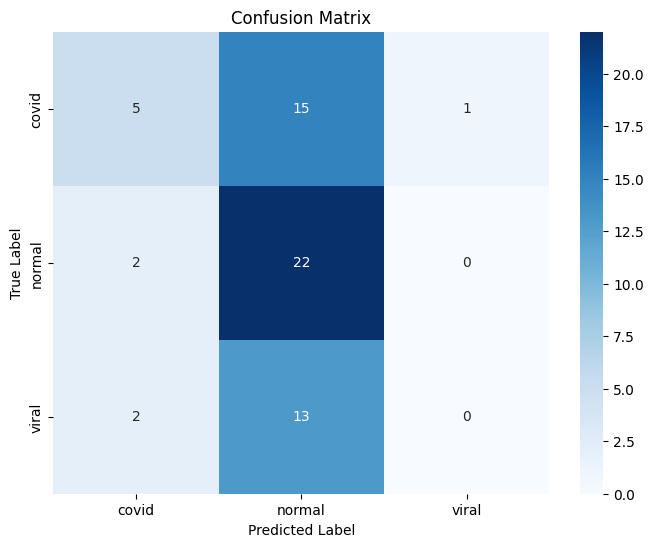


[SUCCESS] Final DenseNet Model saved.


In [61]:
def main():
    print("=== COVID-19 DENSENET121 TRAINING PIPELINE ===")
    
    # 1. Initialize Model
    model, base_model = build_densenet_model((IMG_HEIGHT, IMG_WIDTH, 3))
    
    # 2. Callbacks
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
    callbacks_list = [checkpoint, reduce_lr, early_stop]

    # 3. Load Data
    class_weights = None
    if USE_MOCK_DATA:
        X_train, Y_train = generate_mock_data(300)
        X_val, Y_val = generate_mock_data(60)
    else:
        if not os.path.exists(DATASET_PATH):
            print(f"[ERROR] Dataset not found at {DATASET_PATH}")
            return
        train_gen, val_gen = get_data_generators(DATASET_PATH)
        try:
            class_weights = calculate_class_weights(train_gen)
        except:
            pass

    # --- PHASE 1: TRAIN HEAD ---
    print("\n[PHASE 1] Training Classifier Head...")
    if USE_MOCK_DATA:
        model.fit(X_train, Y_train, epochs=EPOCHS_HEAD, batch_size=BATCH_SIZE, validation_data=(X_val, Y_val), callbacks=callbacks_list)
    else:
        model.fit(train_gen, steps_per_epoch=train_gen.samples // BATCH_SIZE, epochs=EPOCHS_HEAD, validation_data=val_gen, validation_steps=val_gen.samples // BATCH_SIZE, callbacks=callbacks_list, class_weight=class_weights)

    # --- PHASE 2: FINE-TUNING ---
    print("\n[PHASE 2] Fine-Tuning DenseNet121...")
    
    base_model.trainable = True
    
    # DenseNet121 has ~427 layers/blocks. We unfreeze the last 100.
    for layer in base_model.layers[:-100]:
        layer.trainable = False
        
    print("[INFO] Unfroze last 100 layers for fine-tuning.")

    # Recompile with Low LR and Label Smoothing
    model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE_FINE),
                  loss=losses.CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy'])

    if USE_MOCK_DATA:
        model.fit(X_train, Y_train, epochs=EPOCHS_FINE, batch_size=BATCH_SIZE, validation_data=(X_val, Y_val), callbacks=callbacks_list)
        evaluate_model(model, X_val, Y_val, is_generator=False)
    else:
        model.fit(train_gen, steps_per_epoch=train_gen.samples // BATCH_SIZE, epochs=EPOCHS_FINE, validation_data=val_gen, validation_steps=val_gen.samples // BATCH_SIZE, callbacks=callbacks_list, class_weight=class_weights)
        evaluate_model(model, val_gen, None, is_generator=True)

    model.save('covid_detection_model.h5')
    print("\n[SUCCESS] Final DenseNet Model saved.")

if __name__ == "__main__":
    main()